In [178]:
import pandas as pd

<h1>This is a DataFrame that is updated with the infura stream of transactions in gasExpress.py and the results at each block are accessible via a GET request hosted on my server for querying and use as a Gas_price forecast for developers</h1>

In [179]:
df = pd.read_csv('alltx.csv')

<h1>Saved fields from the transaction</h1>

In [180]:
df.describe()

,block_mined,gas,gas_price,hashpower_accepting,round_gp_10gwei,time_mined
count,2.057000e+03,2.057000e+03,2.057000e+03,2057.000000,2057.000000,2.057000e+03
mean,8.904441e+06,2.719904e+05,4.366944e+10,86.185707,435.585805,1.573332e+09
std,9.431148e+00,6.653261e+05,4.449695e+11,12.400127,4449.396470,1.457676e+02
min,8.904427e+06,2.100000e+04,1.000000e+09,72.000000,10.000000,1.573332e+09
25%,8.904434e+06,3.716500e+04,1.100000e+09,72.000000,10.000000,1.573332e+09
50%,8.904441e+06,8.324100e+04,6.000000e+09,84.000000,60.000000,1.573332e+09
75%,8.904449e+06,2.071280e+05,1.331001e+10,100.000000,130.000000,1.573332e+09
max,8.904458e+06,5.300000e+06,9.577651e+12,100.000000,95770.000000,1.573333e+09


<h1>Engineered Feature to look at the gas_price spent and the gas_limit (# of units of the gas)</h1>

In [181]:
df['tx_cost'] = df.gas * df.round_gp_10gwei

<h1>Splitting the removing dependent and independent variables from the df</h1>

In [182]:
X = df[['gas','round_gp_10gwei','tx_cost']]
y = df['hashpower_accepting']

In [183]:
print(X.head())

         gas  round_gp_10gwei     tx_cost
0  1000000.0             90.0  90000000.0
1    43816.0             60.0   2628960.0
2   122777.0            120.0  14733240.0
3   217550.0            100.0  21755000.0
4    83241.0             10.0    832410.0


In [184]:
print(y.head())

0     90
1     84
2    100
3    100
4     72
Name: hashpower_accepting, dtype: int64


<h1>Some Data Exploration to See Obvious Relationships</h1>

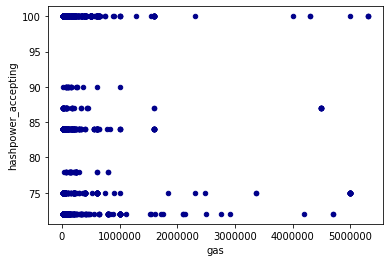

In [185]:
df.plot.scatter(x='gas',
                y='hashpower_accepting',
                c='DarkBlue')

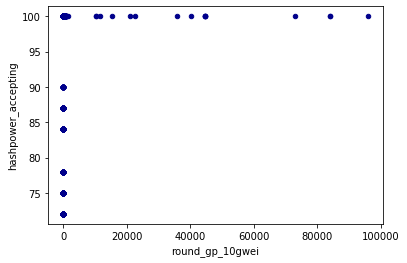

In [186]:
df.plot.scatter(x='round_gp_10gwei',
                y='hashpower_accepting',
                c='DarkBlue',
               )

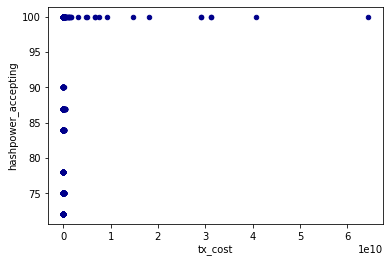

In [187]:
df.plot.scatter(x='tx_cost',
                y='hashpower_accepting',
                c='DarkBlue',
               )

<h1>Getting ready for some ML exploration</h1>

In [188]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

<h1>Linear Models</h1>

<h3>Ridge</h3>

In [189]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=0.01)
clf.fit(X_train, y_train) 

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [190]:
y_pred = clf.predict(X_test)

In [191]:
residuals = y_pred-y_test
residuals.head()

184      2.242677
1947    11.177195
251    -13.761511
1121   -13.692199
1487    14.102690
Name: hashpower_accepting, dtype: float64

In [192]:
clf.score(X,y)

0.010967483966711544

<h3>LinearRegression</h3>

In [193]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [194]:
y_pred = clf.predict(X_test)

In [195]:
residuals = y_pred-y_test
residuals.head()

184      2.242677
1947    11.177195
251    -13.761511
1121   -13.692199
1487    14.102690
Name: hashpower_accepting, dtype: float64

In [196]:
clf.score(X,y)

0.010967483966675906

<h3>Logistic Regression</h3>

In [197]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='multinomial')
clf.fit(X_train, y_train) 

/Users/steven/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [198]:
y_pred = clf.predict(X_test)

In [199]:
residuals = y_pred-y_test
residuals.head()

184     0
1947    0
251     0
1121    0
1487    0
Name: hashpower_accepting, dtype: int64

In [200]:
clf.score(X,y)

0.9718035974720467

Some observations from streaming data.  These different linear models perform better and worse depending on the network congestion.  These numbers are under low network congestion, and perform worse when there is more network congested which is why I investigated more models.

In [201]:
from sklearn import base
class ColumnSelectTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col_names):
        self.col_names = col_names  # We will need these in transform()
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        result=[]
        # Return an array with the same number of rows as X and one
        # column for each in self.col_names
        for row in X:
            row_res = []
            for col in self.col_names:
                row_res.append(row[col])
            result.append(row_res)
        return result
                

In [202]:
from sklearn.pipeline import Pipeline

linear_pipe = Pipeline([
        ('lin', LinearRegression()),
   ])

In [203]:
linear_pipe.fit(X_train, y_train)
linear_pipe.predict(X_test)

array([ 86.24267736,  86.17719532,  86.23848869,  86.30780116,
        86.10268975,  86.23811944,  86.28146181,  86.33823751,
        86.00566541,  86.27431192,  86.26726772,  86.29354378,
        86.29680299,  86.27844131,  86.27895472,  86.26425911,
        86.27887001,  86.27323519,  86.29354378,  86.24630696,
        86.31450099,  86.20146642,  86.31763846,  86.29699678,
        86.23848869,  86.29680299,  86.24802373,  86.35876822,
        86.26726772,  85.38484055,  86.3660356 ,  86.27143997,
        86.3660356 ,  86.10268975,  86.27143997,  86.29104604,
        86.26425911,  86.29354378,  86.1825889 ,  86.27323519,
        86.27924375,  86.33183765,  86.1463712 ,  86.26455539,
        86.38234906,  85.38484055,  85.38484055,  86.29099134,
        86.28430166,  86.30561743,  86.25742006,  86.21040266,
        86.28620662,  86.13859405,  86.24790452,  86.27143997,
        86.19709814,  86.39624052,  86.26483415,  86.42644544,
        86.35999679,  86.27143997,  86.19184866,  86.20

In [204]:
linear_pipe.score(X_test,y_test)

0.007158063818826555

In [205]:
log_pipe = Pipeline([
       ('log', LogisticRegression()),
        ])

In [206]:
log_pipe.fit(X_train, y_train)
log_pipe.predict(X_test)

/Users/steven/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/steven/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([ 84,  75, 100, 100,  72,  84,  75, 100,  84,  75,  72,  84, 100,
        72,  75,  72, 100,  72,  84,  72, 100, 100, 100, 100, 100, 100,
        72, 100,  72,  75, 100,  72, 100,  72,  72, 100,  72,  84,  75,
        72,  75, 100,  84,  84, 100,  75,  75,  84,  75, 100,  72,  72,
        84,  72,  72,  72,  84, 100,  84, 100, 100,  72,  75, 100,  84,
        72, 100,  75, 100, 100,  84,  75, 100,  75,  75, 100,  72,  72,
       100, 100, 100,  75,  75, 100,  72,  72,  84,  75, 100,  72,  84,
        72,  72, 100,  72,  72,  72, 100, 100, 100,  72,  72, 100,  72,
       100,  72, 100,  72, 100,  72, 100,  84, 100,  84,  72,  72, 100,
       100, 100,  72, 100,  72,  72,  72,  72,  72,  84, 100, 100, 100,
        84, 100, 100,  72, 100,  75, 100, 100,  84,  72,  84,  72,  72,
       100, 100,  84,  72, 100,  72, 100, 100, 100,  75, 100, 100,  72,
       100,  72,  84,  75,  84,  72, 100,  84, 100,  72,  75,  84, 100,
       100,  72, 100, 100,  72, 100, 100,  72, 100,  72,  72, 10

In [207]:
log_pipe.score(X_test,y_test)

0.9381443298969072

In [208]:
from sklearn.ensemble import GradientBoostingRegressor

In [209]:
grad_pipe = Pipeline([
       ('log', LogisticRegression()),
        ])

In [210]:
grad_pipe.fit(X_train, y_train)
grad_pipe.predict(X_test)

/Users/steven/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/steven/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([ 84,  75, 100, 100,  72,  84,  75, 100,  84,  75,  72,  84, 100,
        72,  75,  72, 100,  72,  84,  72, 100, 100, 100, 100, 100, 100,
        72, 100,  72,  75, 100,  72, 100,  72,  72, 100,  72,  84,  75,
        72,  75, 100,  84,  84, 100,  75,  75,  84,  75, 100,  72,  72,
        84,  72,  72,  72,  84, 100,  84, 100, 100,  72,  75, 100,  84,
        72, 100,  75, 100, 100,  84,  75, 100,  75,  75, 100,  72,  72,
       100, 100, 100,  75,  75, 100,  72,  72,  84,  75, 100,  72,  84,
        72,  72, 100,  72,  72,  72, 100, 100, 100,  72,  72, 100,  72,
       100,  72, 100,  72, 100,  72, 100,  84, 100,  84,  72,  72, 100,
       100, 100,  72, 100,  72,  72,  72,  72,  72,  84, 100, 100, 100,
        84, 100, 100,  72, 100,  75, 100, 100,  84,  72,  84,  72,  72,
       100, 100,  84,  72, 100,  72, 100, 100, 100,  75, 100, 100,  72,
       100,  72,  84,  75,  84,  72, 100,  84, 100,  72,  75,  84, 100,
       100,  72, 100, 100,  72, 100, 100,  72, 100,  72,  72, 10

In [211]:
grad_pipe.score(X_test,y_test)

0.9381443298969072

<h1>Complex Model</h1>

In [221]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA, TruncatedSVD
union = FeatureUnion([("pca", PCA(n_components=1)),
                      ("svd", TruncatedSVD(n_components=2))])

pipe_all = Pipeline([('union', union), ('grad',GradientBoostingRegressor(n_estimators=300, learning_rate=1.0,max_depth=1, random_state=0))])

In [222]:
%time
pipe_all.fit(X_train,y_train)
print()

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs



In [223]:
y_pred = pipe_all.predict(X_test)
pipe_all.score(X_test,y_test)
#0.67 with just gas and price
#0.81 with 1 component + total_cost
#0.93 with 2 component SGD

##can get up to 0.98 if doing 3 components of PCA, computation takes a long time which isn't ideal

0.9518050094629344

In [224]:
residuals = y_pred-y_test
residuals.head()

184     5.218408
1947   -0.189644
251    -1.340577
1121   -1.863210
1487    0.559119
Name: hashpower_accepting, dtype: float64

In [225]:
y_pred = pipe_all.predict(X_test)
y_pred
###these are the chances to be included in the next block

array([ 89.21840848,  74.81035637,  98.65942341,  98.13678955,
        72.55911873,  89.21840848,  74.85940316, 101.03254685,
        84.23705426,  84.25743718,  71.86379255,  84.37406957,
        99.54014705,  72.1106521 ,  76.119568  ,  72.0924728 ,
        92.53214642,  71.89398196,  84.37406957,  66.85910484,
        98.02520805,  99.74946986,  96.60537668,  90.36367598,
        98.65942341,  99.54014705,  69.99261714, 100.97621564,
        71.86379255,  75.20634007, 100.30842636,  71.92482724,
       100.30842636,  72.55911873,  71.92482724,  92.60947486,
        72.0924728 ,  84.37406957,  81.94714958,  71.89398196,
        76.119568  , 100.38071527,  89.47093382,  88.29307835,
       102.25563738,  75.20634007,  75.20634007,  91.3807933 ,
        77.42967788,  93.01049606,  70.39527515,  70.12093284,
        85.30799159,  72.76293088,  69.99261714,  71.92482724,
        89.47772671, 100.31433074,  86.07597019, 100.27007113,
       101.20045138,  71.92482724,  78.73334474,  99.74

In [226]:
Y = pipe_all.steps[1][1].feature_importances_
cats = X.columns

Index(['gas', 'round_gp_10gwei', 'tx_cost'], dtype='object')
[0.07837305 0.66479766 0.25682929]


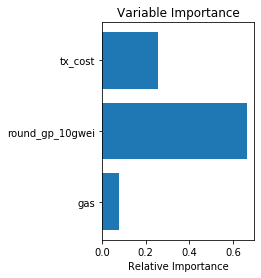

In [227]:
import matplotlib.pyplot as plt
print(cats)
print(Y)
plt.subplot(1, 2, 2)
plt.barh(cats, Y, align='center')
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

####current models don't take into account the gas_limit (gas) - the computation burden of the transaction
#on the network that the user is paying for and they only take into account the gas_price (round_gp_10gwei)

<h1>Here we see that the tx_cost (gas_price * gas_limit) is an import factor to take into consideration when estimating the chance of the transaction being included in the block </h1> 

In [92]:
data = [[21000,50000,333000,21000,50000,333000],[1, 100, 1000,1000,100,1],[21000,5000000,333000000,21000000,5000000,333000]]
df = pd.DataFrame(data,cats).T
df

,gas,round_gp_10gwei,tx_cost
0,21000,1,21000
1,50000,100,5000000
2,333000,1000,333000000
3,21000,1000,21000000
4,50000,100,5000000
5,333000,1,333000


<h1> Making my own test transaction df to look at their chance of inclusion.  These include common gas amounts used on the network with various gas_prices</h1>

In [93]:
X_test = df[['gas','round_gp_10gwei']]
X_test['tx_cost'] = df.gas * df.round_gp_10gwei

<h1>The chance of those transactions being included in the next block on the network</h1>

In [94]:
y_pred = pipe_all.predict(X_test)
y_pred

array([71.01754203, 89.9787487 , 90.21340601, 97.67782833, 89.9787487 ,
       71.01754203])

<h1>Screenshots of Transaction Costs, Confirmation Times on the Network to highlight savings to end users</h1>

<h3>Here we see the blocks from the ethereum network streaming in by the infura node (slowly)</h3>

<#img src="Screen Recording 2019-11-08 at 11.20.55 AM.mov">

<h3>Left is my api hosted locally for query and a competing api commonly used.  Updates on a per block basis waiting for user queries and returning price recommendations for users to place on gas in their ethereum transactions </h3>

<#img src="Screen Recording 2019-11-08 at 11.25.47 AM.mov">

<h3>Cost and Time Comparison of the Two Apis</h3>

In [873]:
import math
def calc_expected_num_blocks(hpa):
    
    if hpa < 100:
        prob =100 - hpa
        
        return math.log(0.05)//math.log(prob/100)
        
    return 1

In [874]:
print('wait time predicted to be: ' + str(calc_wait_time(1)*15/60) + ' min')

wait time predicted to be: 74.5 min
